<a href="https://colab.research.google.com/github/gysdnow/NLPWorks/blob/master/JingDongAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT文本分類 - 京東評論實作

Part1. BERT 模型訓練
- 資料前處理
- 模型訓練
- 模型驗證 (文本、關注點)

Part2. Word2Vec相似詞抽取

---

## 資料集
京東商城使用者評論:

五星評價:57.1萬

一星評價: 3.6萬

---

# 結論
### **BERT**

1.Bert 預訓練模型 有基本的分類能力

2.Fine Tune後 關注重要情緒詞彙的能力提升

3.檢查預測值與 LABEL **相異**資料發現，模型找出負向文本能力較佳 <Br />

> 原因:<Br />
使用者給的[**星級**] 與 使用者評論內容的[**情緒**] 關係不夠清楚 ( 即label不夠乾淨<Br />
或是訓練資料中正負句子參半，導致模型對負向情緒辨識能力較強<Br />
解法: <Br />人工標註完全負面或完全正面的句子，作為訓練資料來訓練模型



### **Jieba、Word2Vec**
1.不特別新增常用、停用詞典的情況下，斷詞能力普通

2.Word2Vec 在資料量大的情況下，找出相似詞的效能更佳
(相較於"酒店評論資料" 7000 餘筆而言)

3.相似詞查找的能力，依賴於結巴斷詞效能。

4.透過相似詞查找，可以較容易歸納出各種詞庫。



In [0]:
import pandas as pd

In [0]:
#Colab
path = 'drive/My Drive/Colab Notebooks/'
#Local
#path = './'
raw_df = pd.read_csv(path + 'article.csv')
raw_df.label.value_counts()

1.0    571832
0.0     36165
Name: label, dtype: int64

## 檢查字數分布
1.所有文章

2.100字以下

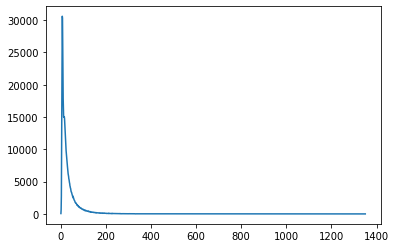

In [0]:
raw_df.text.str.len().value_counts().sort_index().plot()

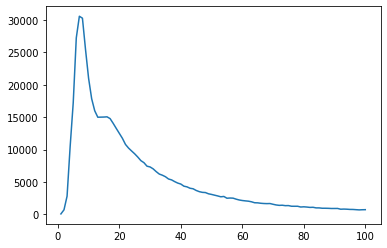

In [0]:
raw_df.text.str.len().value_counts().sort_index()[:100].plot()

##準備訓練資料

取三十字以下的資料

各五千筆進行訓練

In [0]:
len_f = (raw_df.text.str.len()<30) 
neg = raw_df[(raw_df.label == 0) & len_f ].sample(5000)
pos = raw_df[(raw_df.label == 1) & len_f ].sample(5000)
_df = pd.concat([neg,pos]).reset_index(drop=True)
_df

,label,text
0,0.0,画面实在是没有我想像中辣么多
1,0.0,内置摄像头没有，客服复杂，这样的购物体验，实在糟糕
2,0.0,你们的价格怎么能够相信，才几天就降价200
3,0.0,强卖卖了不能退
4,0.0,第一次受骗感觉，8月初买现在弟二次开机坏了
...,...,...
9995,1.0,非常漂亮可爱
9996,1.0,已经装了office和制图软件，关键是很小巧，携带特制方便
9997,1.0,满意很好自营有保障
9998,1.0,買了好幾台了


##儲存處理結果
隨機分為訓練集、驗證集

In [0]:
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(_df, random_state=777, train_size=0.8)
#存檔
train_data.to_csv('./train_jddata.tsv', index=False, sep='\t', encoding='utf-8')
valid_data.to_csv('./valid_jddata.tsv', index=False, sep='\t', encoding='utf-8')

## 資料集讀取Function

In [0]:
!pip install transformers -q
!pip install pysnooper -q
import pysnooper
import torch
from transformers import BertTokenizer,BertForSequenceClassification
from IPython.display import clear_output


PRETRAINED_MODEL_NAME = "bert-base-chinese"  # 指定繁簡中文 BERT-BASE 預訓練模型
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

from torch.utils.data import Dataset
class CommentDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ["train", "valid"] #限制只有這兩種模式
        self.mode = mode 
        self.df = pd.read_csv(mode + "_jddata.tsv", sep="\t").fillna("") #讀對應檔案
        self.len = len(self.df)  
        self.tokenizer = tokenizer  #欲使用的token轉換器
    
    def __getitem__(self, idx):
        #如果是驗證集，不讀取LABEL
        if self.mode == "valid":
            text = self.df.iloc[idx].text
            label_tensor = None
        else:
            label, text = self.df.iloc[idx ,:2].values
            label_tensor = torch.tensor(label,dtype=torch.long)
            
        #[CLS] Sentence Token
        word_pieces = ["[CLS]"]
        tokens = self.tokenizer.tokenize(text)
        word_pieces += tokens
        
        len_a = len(word_pieces)
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        segments_tensor = torch.tensor([0] * len_a ,dtype=torch.long)

        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
trainset = CommentDataset("train", tokenizer=tokenizer)
# 初始化一個專門讀取訓練樣本的 Dataset，使用中文 BERT 斷詞


## 批次載入資料

In [0]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    #取出TOKEN(內容)的TENSOR
    tokens_tensors = [s[0] for s in samples]
    #取出SEGMENT(前後句)的TENSOR（判斷上下句關係時需使用,目前全放0即可）
    segments_tensors = [s[1] for s in samples]
    
    #檢查輸入的資料集有沒有 label 資料
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    #將長短不一的TENSORS tensor 統一用 [PAD] 補齊長度
    tokens_tensors = pad_sequence(tokens_tensors, 
                                  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, 
                                    batch_first=True)
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    #將TOKENS.SHAPE[0]的長度填0，其他填1
    #藉以約束 BERT 可 MASK 的 TENSOR在句子內
    #不至於跑到 [PAD] 處 (MASK PAD無助於 BERT 訓練)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


## 檢查模型參數

In [0]:
#Colab GPU RAM 的關係,取batch size = 32
BATCH_SIZE=32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                         collate_fn = create_mini_batch)

#LABELS 有幾種類別
NUM_LABELS = 2

#建立 BertForSequenceClassification model 
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS, )

clear_output()

print("""
name            module
----------------------""")

for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=2, bias=True)


## 模型預測Function

In [0]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            #取出前三個Return值
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            #填入Model
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            logits = outputs[0]
            #取出該row最大值及其索引()
            #最大值為機率、索引為0,1
            #即BERT所分類之標籤
            _, pred = torch.max(logits.data, 1)
            #如果要算準確率
            if compute_acc:
                #取出dataloader第四個Return list
                labels = data[3]
                #總數等於 default 0 + labels個數
                total += labels.size(0)
                #預測值等於label的數量加總
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions

#開始 FineTune Bert模型

In [0]:
%%time

#有GPU用GPU，沒有的話就用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
#將目前 model 上的數值都 Copy 一份到 device 上
#後續將在該device上操作
model = model.to(device)
model.train()
#優化器選用Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#跑9個epoch
EPOCHS = 9  

for epoch in range(EPOCHS):
    running_loss = 0.0
    # 1 個epoch 跑 n 次Batch
    # 每次 batch 都是一個step
    for data in trainloader:
        #找trainloader拿資料
        #分別放置對應的 list變數
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]
        #歸零梯度參數
        optimizer.zero_grad()
        #將輸入值塞進 model
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        #此處output值第一個變數是loss
        #有提供label作為input時，第一個值會是loss
        #沒有提供時，第一個值會是logits
        loss = outputs[0]
        #反向傳播模型參數
        loss.backward()
        #優化器更新參數
        optimizer.step()

        running_loss += loss.item()
        
    _, acc = get_predictions(model, trainloader, compute_acc=True)

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))
    

device: cuda:0
[epoch 1] loss: 77.952, acc: 0.933
[epoch 2] loss: 47.109, acc: 0.951
[epoch 3] loss: 33.905, acc: 0.961
[epoch 4] loss: 24.921, acc: 0.974
[epoch 5] loss: 18.388, acc: 0.982
[epoch 6] loss: 17.458, acc: 0.980
[epoch 7] loss: 13.256, acc: 0.989
[epoch 8] loss: 10.695, acc: 0.991
[epoch 9] loss: 6.349, acc: 0.993
CPU times: user 5min 8s, sys: 1min 20s, total: 6min 29s
Wall time: 6min 30s


## FineTune完成，進行預測

In [0]:
validset = CommentDataset('valid',tokenizer=tokenizer)
validloader = DataLoader(validset, batch_size=64, 
                        collate_fn=create_mini_batch)
valid_predictions = get_predictions(model, validloader)

In [0]:
valid_df_pred = pd.DataFrame({"predicted": valid_predictions.tolist()})
valid_df = pd.concat([validset.df, valid_df_pred.loc[:, 'predicted']], axis=1)
valid_df.head()

,label,text,predicted
0,1.0,薄薄的本子,1
1,0.0,自动断网是几个意思啊,0
2,1.0,用了一条来评价，准备再添加个内存条,1
3,0.0,新电脑电池损耗已经7%，你懂我的意思吧,0
4,1.0,买来试用两天了，屏幕效果很清晰,1


##檢查預測結果
找出 [BERT預測值] 與 [LABEL] 相異的文本
透過觀察相異文本可以看出 

BERT 是否確實找出判斷類別的特徵依據

最後再將預測結果按照 [原文idx] 進行合併

In [0]:
diff_df = valid_df[valid_df.label != valid_df.predicted].reset_index(drop=True)
diff_df

,label,text,predicted
0,1.0,气味有点大难闻,0
1,1.0,电脑买了大半个月了，也用了大半个月,0
2,1.0,键盘膜和屏幕膜没有送，问过客服后，答应帮我核实补发,0
3,1.0,玩扫雷不卡,0
4,1.0,再也不会卡死机了,0
...,...,...,...
167,1.0,值这六千,0
168,0.0,3349,1
169,1.0,转轴左边排线能看到，看的不太习惯，不知道是不是每台都是这样,0
170,1.0,好货不解释，一买买两台,0


In [0]:
diff_df.label.value_counts()

1.0    121
0.0     51
Name: label, dtype: int64

BERT 預測為負、資料集標註為正


In [0]:
diff_df[diff_df.label==1].sample(10)

,label,text,predicted
50,1.0,这台电脑的制造机构挺好，但是屏幕小气，不太引人注目,0
166,1.0,触摸屏有时候不能用，需要重新打开,0
171,1.0,自己买个包和鼠标吧,0
12,1.0,电脑运行慢,0
43,1.0,刚拿到手上就这样,0
38,1.0,电脑外型很好，但是开机后右键卡顿，运气不太好,0
122,1.0,忘给我发鼠标垫了，应该买粉色的了，会继续跟踪的,0
45,1.0,用这么高级的笔记本，内心都是慌慌的,0
127,1.0,听说还要送个包,0
146,1.0,售后太差，第三天黑屏，不能操作，反应了没人理,0


BERT 預測為正、資料集標註為負

In [0]:
diff_df[diff_df.label==0].sample(10)

,label,text,predicted
100,0.0,和我用了6年的笔记本差不多,1
150,0.0,看视频就这样,1
124,0.0,不是想要的,1
24,0.0,电脑没啥问题京东销售人员打电话推销延保没完没了的说非常#,1
116,0.0,加载同一wifi下游戏本快100倍感觉不值这个价钱,1
19,0.0,京东同款更优惠,1
10,0.0,现在看到此商品还送电脑包,1
85,0.0,跟图片不一样的图案,1
73,0.0,电池续航没用那么强,1
20,0.0,用3d做作业过程中,1


# BertViz
視覺化觀察 Bert 模型的 Attention

In [0]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
!rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip -q install regex
!pip -q install transformers

from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
  

model_type = 'bert'
model_version = 'bert-base-chinese'
o_model = BertModel.from_pretrained(model_version)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "可能期待太高了，没想象中满意"
sentence_b = "买电脑赠的好没有用呢"
call_html()
show(o_model, model_type, tokenizer, sentence_a, sentence_b)

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo
Cloning into 'bertviz_repo'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 1068 (delta 28), reused 40 (delta 18), pack-reused 1013
Receiving objects: 100% (1068/1068), 100.13 MiB | 26.12 MiB/s, done.
Resolving deltas: 100% (677/677), done.


In [0]:
call_html()
finetuned_model  = BertModel.from_pretrained(model_version, 
                                  output_attentions=True, state_dict=model.state_dict())
show(finetuned_model, model_type, tokenizer, sentence_a, sentence_b)

In [0]:
torch.save(model, path + 'Bert_jd_model0408.pt')  
torch.save(model.state_dict(), path + 'Bert_jd_model0408.pt') 

# 詞語處理

Jieba、Word2Vec

In [0]:
!pip install -q jieba
import jieba 

In [0]:
raw_df['jieba_cut'] = raw_df.text.apply(lambda x: list(jieba.cut(str(x))))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.711 seconds.
Prefix dict has been built successfully.


In [0]:
raw_df

,label,text,jieba_cut
0,1.0,电脑也挺好的，美观，大气，键盘的亮度有两档可以调节，画质清晰感人，不错，没玩游戏，所以不知道...,"[电脑, 也, 挺, 好, 的, ，, 美观, ，, 大气, ，, 键盘, 的, 亮度, 有..."
1,1.0,用了一个多月再来评价的，很酷，外观好看，玩游戏很爽，很稳，猛禽模式也不错，游戏本这个声音也能...,"[用, 了, 一个多月, 再, 来, 评价, 的, ，, 很酷, ，, 外观, 好看, ，,..."
2,1.0,昨天晚上下单，今天中午就收到了，笔记本比想象的好看，用鲁大师跑了一下，26w分，我是电脑小白...,"[昨天晚上, 下单, ，, 今天, 中午, 就, 收到, 了, ，, 笔记本, 比, 想象,..."
3,1.0,特地买来玩这个游戏，钟爱十多年的游戏，上一次的结局是一年前，啥也不说，联想66666，质量杠...,"[特地, 买来, 玩, 这个, 游戏, ，, 钟爱, 十多年, 的, 游戏, ，, 上, 一..."
4,1.0,拯救者，没失望的1050TI，512G速度，售后服务也相当贴心，陪着我来来回回安装显卡驱动，...,"[拯救, 者, ，, 没, 失望, 的, 1050TI, ，, 512G, 速度, ，, 售..."
...,...,...,...
607992,0.0,电脑买了一个月总共用了3次，最后一次看视频40分钟出现死机现象，强行关机都不行，最后电耗光之...,"[电脑, 买, 了, 一个月, 总共, 用, 了, 3, 次, ，, 最后, 一次, 看, ..."
607993,0.0,非常糟糕的购物经历，外置电池极为丑陋，启动极慢，打开个word都要老半天，硬盘发出咯吱咯吱的...,"[非常, 糟糕, 的, 购物, 经历, ，, 外置, 电池, 极为, 丑陋, ，, 启动, ..."
607994,0.0,电脑到货无加装1T硬盘，不愿换货，寄回去加装硬盘，寄回来电脑屏幕出现弧度，键盘翘起压不进去，...,"[电脑, 到货, 无, 加装, 1T, 硬盘, ，, 不愿, 换货, ，, 寄, 回去, 加..."
607995,0.0,电脑速度特别慢，新电脑都不如旧电脑快,"[电脑, 速度, 特别, 慢, ，, 新, 电脑, 都, 不如, 旧电脑, 快]"


In [0]:
import jieba.analyse
jieba.analyse.extract_tags(raw_df.text[5], topK=10, withWeight=False, allowPOS=())

['高性能', 'Y7000', '显卡', '窄边', '512', '游戏机', '硬盘', '送货', '处理器', '超大']

In [0]:
jieba.analyse.textrank(raw_df.text[5], topK=10, withWeight=False, allowPOS=('ns', 'n', 'vn', 'v'))

['高性能', '超大', '硬盘', '固态', '实惠', '价格', '联想', '拯救', '显卡', '性价比']

In [0]:
result = jieba.tokenize(raw_df.text[5], mode='search')
for tk in result:
    print("<{:5}>\t start: {} \t end:{}".format(tk[0],tk[1],tk[2]))

<送货   >	 start: 0 	 end:2
<快    >	 start: 2 	 end:3
<，    >	 start: 3 	 end:4
<价格   >	 start: 4 	 end:6
<实惠   >	 start: 6 	 end:8
<，    >	 start: 8 	 end:9
<联想   >	 start: 9 	 end:11
<拯救   >	 start: 11 	 end:13
<者    >	 start: 13 	 end:14
<游戏   >	 start: 14 	 end:16
<游戏机  >	 start: 14 	 end:17
<型    >	 start: 17 	 end:18
<Y7000>	 start: 18 	 end:23
<，    >	 start: 23 	 end:24
<高性   >	 start: 24 	 end:26
<性能   >	 start: 25 	 end:27
<高性能  >	 start: 24 	 end:27
<处理   >	 start: 27 	 end:29
<理器   >	 start: 28 	 end:30
<处理器  >	 start: 27 	 end:30
<，    >	 start: 30 	 end:31
<高性   >	 start: 31 	 end:33
<性能   >	 start: 32 	 end:34
<高性能  >	 start: 31 	 end:34
<显卡   >	 start: 34 	 end:36
<，    >	 start: 36 	 end:37
<性价比  >	 start: 37 	 end:40
<很    >	 start: 40 	 end:41
<高    >	 start: 41 	 end:42
<的    >	 start: 42 	 end:43
<一款   >	 start: 43 	 end:45
<笔记   >	 start: 45 	 end:47
<笔记本  >	 start: 45 	 end:48
<，    >	 start: 48 	 end:49
<窄边   >	 start: 49 	 end:51
<设计   >	 start: 51 	 end:53
<，   

In [0]:
!pip install -q gensim
from gensim.models.word2vec import Word2Vec

def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

In [0]:
wv_model = Word2Vec(raw_df['jieba_cut'],size=250,iter=8)
#尋找相似詞 top10
most_similar(wv_model,['酒店','房间','硬件','价格'],10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,酒店,cos,房间,cos,硬件,cos,价格,cos
0,小区,0.667272,寝室,0.677294,电脑硬件,0.659709,价钱,0.854433
1,门口,0.656619,被窝,0.655841,软硬件,0.515487,价位,0.740181
2,宾馆,0.615980,空调,0.654762,主板,0.476839,价,0.718730
3,镇上,0.612556,客厅,0.652056,参数,0.474304,售价,0.651260
4,门卫,0.608100,床上,0.623223,指标,0.468416,价买,0.608928
5,保安,0.591808,阳台,0.619251,部件,0.461141,产品价格,0.607639
6,楼下,0.590800,卧室,0.604281,各项,0.452931,价了,0.585766
7,加班,0.588647,腿,0.602837,检测工具,0.448818,商品价格,0.556917
8,外地,0.578080,桌子,0.601317,内部,0.446581,价还算,0.518051
9,物业,0.577804,被子,0.598795,性能,0.437622,价挺,0.517037


In [0]:
most_similar(wv_model,['屏','显卡','硬件','价格'],10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,屏,cos,显卡,cos,硬件,cos,价格,cos
0,屏幕,0.723737,独显,0.702435,电脑硬件,0.659709,价钱,0.854433
1,屏是,0.718279,显存,0.682849,软硬件,0.515487,价位,0.740181
2,显示屏,0.701138,核显,0.669957,主板,0.476839,价,0.718730
3,屏超,0.647115,集成显卡,0.628349,参数,0.474304,售价,0.651260
4,屏好,0.644721,英,0.624718,指标,0.468416,价买,0.608928
5,屏加,0.626702,mx150,0.622054,部件,0.461141,产品价格,0.607639
6,屏下,0.617263,1050ti,0.621518,各项,0.452931,价了,0.585766
7,显示器,0.614030,MX150,0.610415,检测工具,0.448818,商品价格,0.556917
8,屏买,0.600701,CPU,0.601478,内部,0.446581,价还算,0.518051
9,屏会,0.592856,集显,0.599526,性能,0.437622,价挺,0.517037
